In [122]:
class A:
    def __init__(self):
        print('ok')
    def aaa(self,a):
        print(a)
        

In [123]:
aaaa=A()

ok


In [127]:
aaaa.aaa.a

AttributeError: 'function' object has no attribute 'a'

In [2]:
pwd

'C:\\Users\\Administrator\\Desktop\\hyram-master3.0\\hyram-master\\src\\hyram\\hyram\\phys'

In [282]:
from _comps import Fluid,Orifice

In [283]:
f=Fluid(species='H2',T=249.95, P=70000000,)

In [284]:
a=Fluid(species='air',T=288.15, P=100000,)

In [285]:
o=Orifice(0.003)

In [286]:
f=Flame(f,o,a,theta0=1.57)

s0 0.17105383499804666
solving for the flame...done.
solve [1.71053835e-01 1.73466165e-01 1.75162041e-01 1.76665413e-01
 1.78363268e-01 1.80084284e-01 1.81776805e-01 1.83732376e-01
 1.85748584e-01 1.88012386e-01 1.90134269e-01 1.92676261e-01
 1.94947316e-01 1.96986539e-01 1.99439504e-01 2.02300156e-01
 2.04721057e-01 2.08060039e-01 2.10994308e-01 2.14344977e-01
 2.19086983e-01 2.23559148e-01 2.31261105e-01 2.41590217e-01
 2.53005968e-01 2.69646026e-01 2.86526651e-01 3.04294473e-01
 3.05651609e-01 3.07008746e-01 3.08113965e-01 3.09219183e-01
 3.09303410e-01 3.09387637e-01 3.09400532e-01 3.09413426e-01
 3.09421543e-01 3.09502711e-01 3.10314395e-01 3.11812450e-01
 3.14845925e-01 3.19553691e-01 3.28618483e-01 3.38540229e-01
 3.50984523e-01 3.64617103e-01 3.79421355e-01 3.97264679e-01
 4.16241296e-01 4.37541138e-01 4.63770081e-01 4.95503512e-01
 5.08762317e-01 5.22021121e-01 5.34507618e-01 5.65990644e-01
 5.97301271e-01 6.27236368e-01 6.61136133e-01 6.78995101e-01
 6.84391595e-01 6.89788089

[[-10.16967449  -8.82942526  -7.6658035  ...   7.66607593   8.82969769
   10.16994692]
 [-10.16967257  -8.82942334  -7.66580158 ...   7.66607785   8.82969961
   10.16994884]
 [-10.16967122  -8.82942199  -7.66580023 ...   7.6660792    8.82970096
   10.16995019]
 ...
 [-10.13477643  -8.79452677  -7.63090465 ...   7.70097963   8.86460175
   10.20485141]
 [-10.13427802  -8.79402836  -7.63040623 ...   7.70147804   8.86510017
   10.20534983]
 [-10.13378188  -8.79353222  -7.6299101  ...   7.70197418   8.86559631
   10.20584596]] [[1.79152275e-01 1.78084999e-01 1.77158375e-01 ... 1.64949186e-01
  1.64022563e-01 1.62955286e-01]
 [1.81564599e-01 1.80497323e-01 1.79570700e-01 ... 1.67361520e-01
  1.66434897e-01 1.65367622e-01]
 [1.83260470e-01 1.82193195e-01 1.81266573e-01 ... 1.69057399e-01
  1.68130777e-01 1.67063501e-01]
 ...
 [1.79505234e+02 1.79505165e+02 1.79505105e+02 ... 1.79504312e+02
  1.79504252e+02 1.79504182e+02]
 [1.89452008e+02 1.89451943e+02 1.89451887e+02 ... 1.89451142e+02
  1.8

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x22fc0520388>)

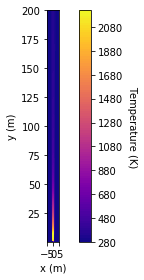

In [287]:
f.plot_Ts(xlims = (-5,5))

In [281]:
from __future__ import print_function, absolute_import, division

import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import constants as const
from scipy import integrate, interpolate, optimize
# TODO remove skimage dependency?
from skimage import measure

from _jet import DevelopingFlow
from _therm import Combustion


class Flame:
    def __init__(self, fluid, orifice, ambient, nC=0, mdot=None,
                 theta0=0., x0=0, y0=0,
                 nn_conserve_momentum=True, nn_T='solve_energy',
                 chem=None,
                 lamf=1.24, lamv=1.24, betaA=3.42e-2, alpha_buoy=5.75e-4, af=0.23,
                 T_establish_min=-1, verbose=True,
                 Smax=np.inf, dS=None, tol=1e-8, max_steps=8000,
                 numB=5, n_pts_integral=100
                 ):
        '''
        class for calculating the characteristics of a 2-D flame, without wind
        see Ekoto et al. International Journal of Hydrogen Energy, 39, 2014 (20570-20577)
        
        Parameters
        ----------
        fluid: Fluid object (hc_comps)
            fluid that is being released
        orifice: Orifice object (h2_comps)
            orifice through which fluid is being released
        ambient: Fluid object (hc_comps)
            fluid into which release is occuring
        nC: int
            number of carbon atoms (0 for H2, 1 for CH4, 2 for C2H6, 3 for C3H8)
        mdot: float, optional 
            should only be specified for subsonic release, mass flow rate (kg/s)
        theta0 : float, optional
            angle of release (rad) default value of 0 is horizontal
        x0 : float, optional
            horizontal starting point (m)
        y0 : float, optional
            vertical starting point (m)
        nn_conserve_momentum: boolean, optional
            whether notional nozzle model should conserve mass and momentum, or mass only,
            together with nn_T determines which notional nozzle model to use (see below)
        nn_T: string, optional
            either 'solve_energy', 'Tthroat' or specified temperature (stagnation temperature) 
            with nn_conserve_momentum leads to one of the following notinoal nozzle models:
            YuceilOtugen - conserve_momentum = True, T = 'solve_energy'
            EwanMoodie - conserve_momentum = False, T = 'Tthroat'
            Birch - conserve_momentum = False, T = T0
            Birch2 - conserve_momentum = True, T = T0
            Molkov - conserve_momentum = False, T = 'solve_energy'
        chem : chemistry class (see hc_therm for usage), optional
            if none given, will initialize new chemisty class
        lamf : float
            spreading ratio for mixture fraction Gaussian profile
        lamv : float
            spreading ratio for velocity Gaussian profile
        betaA : float
            momentum entrainment coefficient
        alpha_buoy : float
            buoyancy entrainment coefficient    
        af : float
            Plank's mean absorption coefficient for H2O
        T_establish_min: float, optional
            minimum temperature for start of integral model
        Smax: float, optional
            limit of integration, integrator will stop when it reaches minimum of Flame.length() or Smax
        dS: float, optional
            integrator step size, if None, defaults to Smax/Flame.length() solver adds steps in high gradient areas
        tol: float, optional
            relative and absolute tolerance for integrator
        max_steps: float, optional
            maximum steps for integrator
        numB: float, optional
            maximum number of halfwidths (B) considered to be infinity - for integration in equations
        n_pts_integral: int, optional
            maximum number of points in integration (from 0 to numB)
        '''
        self.x, self.y, self.S = [], [], []
        self.developing_flow = DevelopingFlow(fluid, orifice, ambient, mdot,
                                              theta0=theta0, x0=x0, y0=y0,
                                              lam=lamf, betaA=betaA,
                                              nn_conserve_momentum=nn_conserve_momentum, nn_T=nn_T,
                                              T_establish_min=T_establish_min,
                                              )
        self.initial_node = self.developing_flow.initial_node
        expanded_plug_node = self.developing_flow.expanded_plug_node

        self.fluid, self.ambient = fluid, ambient
        self.Emom = betaA * np.sqrt(const.pi / 4.0 * expanded_plug_node.d ** 2 *
                                    expanded_plug_node.rho * expanded_plug_node.v ** 2 / ambient.rho)
        self.theta0, self.lamf, self.lamv, self.alpha_buoy = theta0, lamf, lamv, alpha_buoy
        self.chem = chem
        self.af = af
        self.nC = nC
        self.x0, self.y0, self.S0 = x0, y0, self.initial_node.S
        print('s0',self.S0)
        self.verbose = verbose
        self.solve(Smax, dS, tol, max_steps, numB, n_pts_integral)
        

    def _govEqns(self, S, ind_vars, numB=5, n_pts_integral=100):
        '''
        Governing equations for a flame, written in terms of d/dS of (V_cl, B, theta, f_cl, x, and y).
        
        A matrix soluition to the continuity, x-momentum, y-mometum and mixture fraction equations
        solves for d/dS of the dependent variables V_cl, B, theta, and f_cl.  Numerically integrated
        to infinity = numB * B(S) using numpts discrete points.'''

        # break independent variables out of ind_vars
        [V_cl, B, theta, f_cl, x, y] = ind_vars

        # needed to integrate to infinity (6B):
        r = np.zeros(n_pts_integral)
        r[1:] = np.logspace(-7, np.log10(numB * B), n_pts_integral - 1)

        # mass fraction and velocity have Gaussian shapes
        f = f_cl * np.exp(-(r / (self.lamf * B)) ** 2)
        V = V_cl * np.exp(-(r / (self.lamv * B)) ** 2)

        # density isn't a nice Gaussian, due to combustion 
        try:
            rho = self.chem.rho_prod(f)
            drhodf = self.chem.drhodf(f)
        except:
            warnings.warn('clipping f - something has gone wrong')
            f = np.clip(f, 0, 1)
            rho = self.chem.rho_prod(f)
            drhodf = self.chem.drhodf(f)

        rho_int = integrate.trapz(self.ambient.rho - rho, r)

        Ebuoy = 2 * np.pi * self.alpha_buoy * np.sin(theta) * (
                    const.g * (rho_int) / (B * V_cl * self.developing_flow.fluid_exp.rho))  # m**2/s
        E = self.Emom + Ebuoy

        # right-hand side of governing equations:
        RHS = np.array([self.ambient.rho * E / (2 * const.pi),  # continuity
                        0,  # x-momentum
                        integrate.trapz((self.ambient.rho - rho) * const.g * r, r),  # y-momentum
                        0])  # mixture fraction

        # some terms that are needed
        zero = np.zeros_like(r)
        dfdS = np.array([zero, 2 * r ** 2 / self.lamf ** 2 / B ** 3 * f, zero, f / f_cl])
        dVdS = np.array([V / V_cl, 2 * r ** 2 / self.lamv ** 2 / B ** 3 * V, zero, zero])
        drhodS = drhodf * dfdS
        dthetadS = np.array([zero, zero, np.ones_like(r), zero])

        # left-hand side of governing equations:
        LHS = np.array([drhodS * V * r + rho * dVdS * r,  # continuity
                        drhodS * V ** 2 * np.cos(theta) * r + 2 * rho * V * dVdS * np.cos(
                            theta) * r + rho * V ** 2 * -np.sin(theta) * dthetadS * r,  # x-momentum
                        drhodS * V ** 2 * np.sin(theta) * r + 2 * rho * V * dVdS * np.sin(
                            theta) * r + rho * V ** 2 * np.cos(theta) * dthetadS * r,  # y-momentum
                        drhodS * V * f * r + rho * dVdS * f * r + rho * V * dfdS * r])  # mixture fraction
        LHS = integrate.trapz(LHS, r)

        dz = np.append(np.linalg.solve(LHS, RHS), np.array([np.cos(theta), np.sin(theta)]), axis=0)

        return dz

    def solve(self, Smax=np.inf, dS=None, tol=1e-8, max_steps=5000,
              numB=5, n_pts_integral=100):
        '''
        Solves for a flame. Returns a dictionary of flame results.  Also updates the Flame class with those results.
        
        Parameters
        ----------
        Smax : float, optional
            endopoint along curved flame for integration (m) default will calculate visible length of flame
        
        Returns
        -------
        res : dict
            dictionary of flame results
        '''
        try:
            if self.chem.Treac != self.ambient.T or abs(self.chem.P / self.ambient.P - 1) > 1e-10:
                self.chem.reinitilize(self.ambient.T, self.nC, self.ambient.P)
        except:
            self.chem = Combustion(self.ambient.T, self.nC, self.ambient.P)

        if self.verbose:
            print('solving for the flame...', end='')
        Smax = min(Smax,200.0)###############self.length()

        Y_clE = self.initial_node.Y_cl
        f_clE = optimize.newton(lambda f: Y_clE - self.chem._Yprod(f)[self.chem.reac],
                                Y_clE)  # supposed to be ??Y_reac??
        thetaE = self.theta0
        SE = self.initial_node.S
        xE = self.x0 + SE * np.cos(thetaE)
        yE = self.y0 + SE * np.sin(thetaE)
        
        r = integrate.ode(self._govEqns).set_integrator('dopri5', atol=tol, rtol=tol)
        S, solution = [], []
        r.set_f_params(numB, n_pts_integral)
        r.set_initial_value(np.array([self.initial_node.v_cl, self.initial_node.B, thetaE, f_clE, xE, yE]), SE)

        def solout(s, solution_s):
            S.append(s)
            solution.append(np.array(solution_s))

        r.set_solout(solout)

        i = 0
        if dS == None:
            dS = Smax - r.t
        while r.successful() and i < max_steps and r.t < Smax:
            r.integrate(r.t + dS)
            i += 1

        S, solution = np.array(S), np.array(solution)
        res = dict(zip(['V_cl', 'B', 'theta', 'f_cl', 'x', 'y'], solution.T))
        res['S'] = S
        for k, v in res.items():
            self.__dict__[k] = v
        if self.verbose:
            print('done.')
        print('solve',self.S)
        return res

    def length(self):
        '''
        These correlations come from Schefer et al. IJHE 31 (2006): 1332-1340
        and Molina et al PCI 31 (2007): 2565-2572
        
        returns the visible flame length
        also updates the flame class with 
        
        .Lvis (flame length), 
        .Wf (flame width), 
        .tauf (flame residence time)
        .Xrad (radiant fraction)
        '''
        try:
            if self.chem.Treac != self.ambient.T or abs(self.chem.P / self.ambient.P - 1) > 1e-10:
                self.chem.reinitilize(self.ambient.T, self.nC, self.ambient.P)
        except:
            self.chem = Combustion(self.ambient.T, self.nC, self.ambient.P, self.numpts)
        fs, Tad = self.chem.fstoich, self.chem.T_prod(self.chem.fstoich)
        Tamb = self.ambient.T
        rhoair, rhof = self.ambient.rho, self.chem.rho_prod(self.chem.fstoich)
        orifice1, gas1 = self.developing_flow.orifice_exp, self.developing_flow.fluid_exp
        Deff, rhoeff = orifice1.d, gas1.rho

        # Compute the flame Froude number
        Frf = (gas1.v * fs ** 1.5) / (((rhoeff / rhoair) ** 0.25) * np.sqrt(((Tad - Tamb) / Tamb) * const.g * Deff))

        # Compute visible flame length
        Lstar = ((13.5 * Frf ** 0.4) / (1 + 0.07 * Frf ** 2) ** 0.2) * (Frf < 5) + 23 * (Frf >= 5)

        dstar = Deff * (rhoeff / rhoair) ** 0.5

        self.Lvis = Lstar * dstar / fs  # visible flame length [m]
        self.Wf = 0.17 * self.Lvis
        # flame residence time [ms]

        self.tauf = (const.pi / 12) * (rhof * (self.Wf ** 2) * self.Lvis * fs) / (orifice1.mdot(gas1)) * 1000
        # self.Xrad = (0.08916*np.log10(self.tauf*self.af*Tad**4) - 1.2172) # comes from Molina et al.
        self.Xrad = 9.45e-9 * (self.tauf * self.af * Tad ** 4) ** 0.47  # see Panda, Hecht, IJHE 2016
        return self.Lvis


    def _contourdata(self):
        #print(self.S)
        iS = np.arange(len(self.S))
        r = np.append(
            np.append(-np.logspace(np.log10(10 * max(self.B)), -2), np.linspace(-10 ** -2.1, 10 ** -2.1, num=10)),
            np.logspace(-2, np.log10(10 * max(self.B))))
        r, iS = np.meshgrid(r, iS)
        B = self.B[iS]
        f_cl = self.f_cl[iS]

        fvals = f_cl * np.exp(-(r / (self.lamf * B)) ** 2)
        Tvals = self.chem.T_prod(fvals)

        x = self.x[iS] + r * np.sin(self.theta[iS])
        y = self.y[iS] - r * np.cos(self.theta[iS])
        return x, y, Tvals

    def plot_Ts(self, mark=None, mcolors='w',
                xlims=None, ylims=None,
                xlab='x (m)', ylab='y (m)',
                cp_params={}, levels=100,
                addColorBar=True, aspect=1, plot_title=None,
                fig_params={}, subplots_params={}, ax=None):
        '''
        makes temperature contour plot
        
        Parameters
        ----------
        mark: list, optional
            levels to draw contour lines (Temperatures, or None if None desired)
        mcolors: color or list of colors, optional
            colors of marked contour leves
        xlims: tuple, optional
            tuple of (xmin, xmax) for contour plot
        ylims: tuple, optional
            tuple of (ymin, ymax) for contour plot
        vmin: float, optional
            minimum mole fraction for contour plot
        vmax: float, optional
            maximum mole fraction for contour plot
        levels: int, optional
            number of contours levels to draw
        addColorBar: boolean, optional
            whether to add a colorbar to the plot
        aspect: float, optional
            aspect ratio of plot
        fig_parameters: optional
            dictionary of figure parameters (e.g. figsize)
        subplots_params: optional
            dictionary of subplots_adjust parameters (e.g. top)
        ax: optional
            axes on which to make the plot
        '''
        if ax is None:
            fig, ax = plt.subplots(**fig_params)
            plt.subplots_adjust(**subplots_params)
        else:
            fig = ax.figure

        x, y, T = self._contourdata()
        # clrmap = 'Spectral_r'
        clrmap = 'plasma'
        ax.set_facecolor(plt.cm.get_cmap(clrmap)(0))  # old matplotlib: ax.set_axis_bgcolor
        cp = ax.contourf(x, y, T, levels, cmap=clrmap, **cp_params)
        print(x,y)
        if mark is not None:
            cp2 = ax.contour(x, y, T, levels=mark, colors=mcolors, linewidths=1.5, **cp_params)

        if xlims is not None:
            ax.set_xlim(*xlims)
        if ylims is not None:
            ax.set_ylim(*ylims)

        if addColorBar:
            cb = plt.colorbar(cp)
            cb.set_label('Temperature (K)', rotation=-90, va='bottom')
        else:
            cb = None

        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        if aspect is not None:
            ax.set_aspect(aspect)
        if plot_title is not None:
            ax.set_title(plot_title)
        fig.tight_layout()

        return fig, cb
    def generate_positional_flux(self, x, y, z, rel_humid, rad_src_model):
        """ Calculate flux at positions according to radiative source model

        Parameters
        ----------
        x : ndarray
            x coordinates (m)

        y : ndarray
            y coordinates (m)

        z : ndarray
            z coordinates (m)

        rel_humid : flat
            relative humitidy

        rad_src_model : str
            radiative source model

        Returns
        -------
        flux : ndarray
            flux values at specified positions (kW/m^2)
        """
        if rad_src_model == "multi":
            flux = self.Qrad_multi(x, y, z, rel_humid)

        else:
            Lvis = self.length()
            flame_center = np.array([self.x[np.argmin(np.abs(self.S - Lvis / 2))],
                                     self.y[np.argmin(np.abs(self.S - Lvis / 2))],
                                     0])
            flux = self.Qrad_single(x, y, z, flame_center, rel_humid)

        return flux

